In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [8]:
# Setup folder for data

# Get current working directory
cwd = os.getcwd()

# Set data folder location
data_loc = os.path.join(cwd, "Data")

# Search for data folder
if data_loc not in os.listdir(cwd):

    # Create data folder if not found
    os.makedirs(data_loc)

In [88]:
#Create a clean data set of a specified size
def create_data(size):

    x_vals = [np.linspace(0, np.random.randint(1,20)*np.pi, 1000) for i in range(size)]
    y_vals = [np.sin(x) for x in x_vals]
    classification = ["Clean" for x in x_vals]
        
    entry = {
        "X": x_vals,
        "Y": y_vals,
        "Classification": classification
    }

    return entry

#Create a noisy array from an array of input x-values
def apply_noise(xarr):
    return [np.sin(x) + np.random.normal(0, 0.5, 1000) for x in xarr]

In [101]:
#Create 50 clean data sets with random periods
data_set = create_data(50)

x_vals = data_set["X"]
y_vals = data_set["Y"]
classification = data_set["Classification"]

#Create a noisy data set and classifier list 
y_vals_noise = apply_noise(x_vals)
classification_noise = ["Noisy" for i in range(len(x_vals))]

data_set["X"] = x_vals + x_vals
data_set["Y"] = y_vals + y_vals_noise
data_set["Classification"] = classification + classification_noise

In [102]:
data = pd.DataFrame(data_set)
data.to_csv(f"{data_loc}/data.csv")

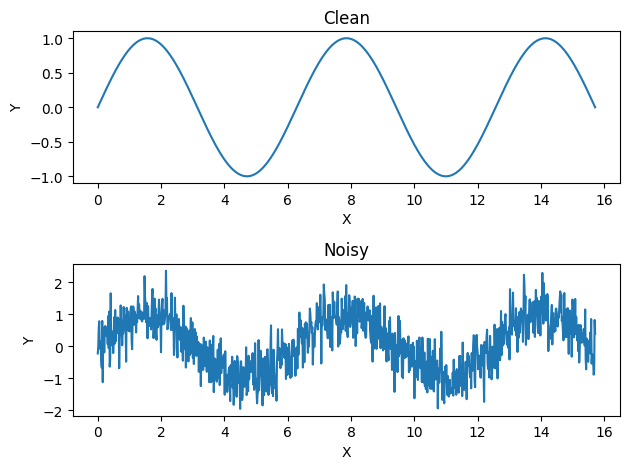

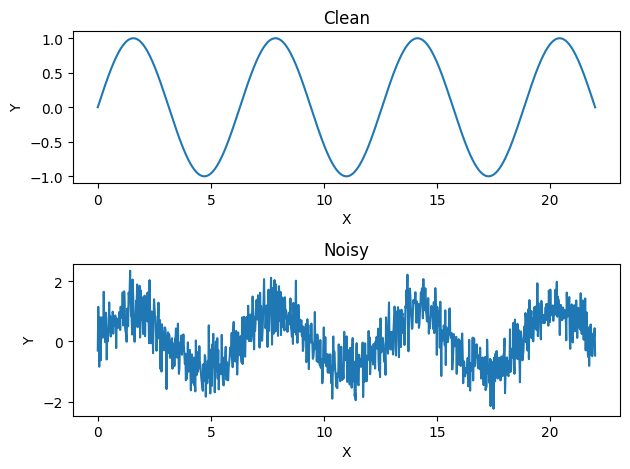

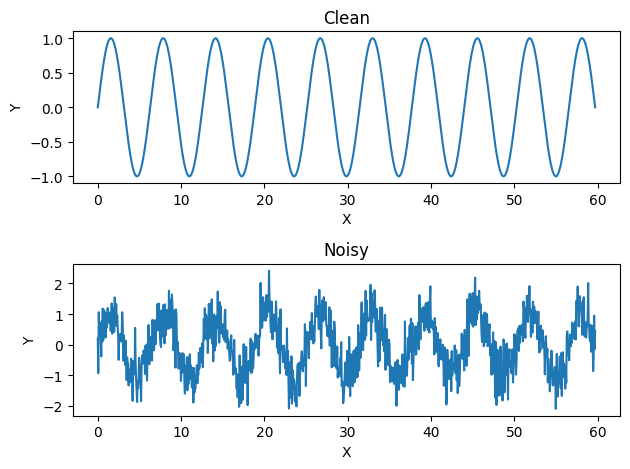

In [103]:
y_data = np.asarray(data["Y"])
x_data = np.asarray(data["X"])

index = [np.random.randint(1,50) for x in range(3)]

for i in index:
    plt.figure()
    plt.subplot(211)
    plt.title("Clean")
    plt.plot(x_data[i], y_data[i])
    plt.xlabel("X")
    plt.ylabel("Y")

    plt.subplot(212)
    plt.title("Noisy")
    plt.plot(x_data[i+50], y_data[i+50])
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.tight_layout()
    plt.show()